In [1]:
import os
import re
import numpy as np
import pydot
import rmgpy.tools.fluxdiagram
from rmgpy.solver.base import TerminationTime
from rmgpy.solver.liquid import LiquidReactor
from rmgpy.kinetics.diffusionLimited import diffusion_limiter

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

## Settings

In [2]:
# Options controlling the individual flux diagram renderings:
program = 'dot'  # The program to use to lay out the nodes and edges
max_node_count = 50  # The maximum number of nodes to show in the diagram
max_edge_count = 50  # The maximum number of edges to show in the diagram
concentration_tol = 1e-6  # The lowest fractional concentration to show (values below this will appear as zero)
species_rate_tol = 1e-6  # The lowest fractional species rate to show (values below this will appear as zero)
max_node_pen_width = 10.0  # The thickness of the border around a node at maximum concentration
max_edge_pen_width = 10.0  # The thickness of the edge at maximum species rate
radius = 1  # The graph radius to plot around a central species
central_reaction_count = None  # The maximum number of reactions to draw from each central species (None draws all)
# If radius > 1, then this is the number of reactions from every species

# Options controlling the ODE simulations:
initial_time = 1e-12  # The time at which to initiate the simulation, in seconds
time_step = 10 ** 0.1  # The multiplicative factor to use between consecutive time points
abs_tol = 1e-16  # The absolute tolerance to use in the ODE simluations
rel_tol = 1e-8  # The relative tolerance to use in the ODE simulations

# Options controlling the generated movie:
video_fps = 6  # The number of frames per second in the generated movie
initial_padding = 5  # The number of seconds to display the initial fluxes at the start of the video
final_padding = 5  # The number of seconds to display the final fluxes at the end of the video


species_path = None
java = False            # always False
settings = None
chemkin_output = ''     # this will be generated automatically
central_species_list = None
superimpose = False     # this will always be false, delete it
save_states = False
read_states = False     # fine to keep this always false and delete relevant code below
diffusion_limited = True
check_duplicates = True

## Load Mechanisms

In [3]:
rmg_input_file = '/home/moon/rmg/mech_viz/example_diff/input.py'  # for conditions

mech_1_inp = '/home/moon/rmg/mech_viz/example_diff/chem_annotated.inp'
mech_1_dict = '/home/moon/rmg/mech_viz/example_diff/species_dictionary.txt'

mech_2_inp = '/home/moon/rmg/mech_viz/example_diff/sp85_with_rotors.inp'
mech_2_dict = '/home/moon/rmg/mech_viz/example_diff/species_dictionary.txt'


if species_path is None:
    species_path = os.path.join(os.path.dirname(rmg_input_file), 'species')
    generate_images = True
else:
    generate_images = False

print('Loading RMG job 1...')
rmg_job1 = rmgpy.tools.fluxdiagram.load_rmg_job(
    rmg_input_file,
    mech_1_inp,
    mech_1_dict,
    generate_images=generate_images,
    check_duplicates=check_duplicates
)

print('Loading RMG job 2...')
rmg_job2 = rmgpy.tools.fluxdiagram.load_rmg_job(
    rmg_input_file,
    mech_2_inp,
    mech_2_dict,
    generate_images=generate_images,
    check_duplicates=check_duplicates
)

Loading RMG job 1...


Loading RMG job 2...


## Simulation

In [4]:
print('Conducting simulation of reaction 1')
times1, concentrations1, reaction_rates1 = rmgpy.tools.fluxdiagram.simulate(
    rmg_job1.reaction_model,
    rmg_job1.reaction_systems[0],
    settings
)

print('Conducting simulation of reaction 2')
times2, concentrations2, reaction_rates2 = rmgpy.tools.fluxdiagram.simulate(
    rmg_job2.reaction_model,
    rmg_job2.reaction_systems[0],
    settings
)

Conducting simulation of reaction 1
Conducting simulation of reaction 2


In [5]:
# okay, for now let's assume the mechanisms are identically named,
# and have the exact same list of species and reactions but with different parameters

In [6]:
species_list1 = rmg_job1.reaction_model.core.species[:]
num_species1 = len(species_list1)
reaction_list1 = rmg_job1.reaction_model.core.reactions[:]

species_list2 = rmg_job2.reaction_model.core.species[:]
num_species2 = len(species_list2)
reaction_list2 = rmg_job2.reaction_model.core.reactions[:]


In [7]:
# Compute the rates between each pair of species (big matrix warning!)
species_rates1 = np.zeros((len(times1), num_species1, num_species1), np.float64)
for index, reaction in enumerate(reaction_list1):
    rate = reaction_rates1[:, index]
    if not reaction.pairs: reaction.generate_pairs()
    for reactant, product in reaction.pairs:
        reactant_index = species_list1.index(reactant)
        product_index = species_list1.index(product)
        species_rates1[:, reactant_index, product_index] += rate
        species_rates1[:, product_index, reactant_index] -= rate
        
species_rates2 = np.zeros((len(times2), num_species2, num_species2), np.float64)
for index, reaction in enumerate(reaction_list2):
    rate = reaction_rates2[:, index]
    if not reaction.pairs: reaction.generate_pairs()
    for reactant, product in reaction.pairs:
        reactant_index = species_list2.index(reactant)
        product_index = species_list2.index(product)
        species_rates2[:, reactant_index, product_index] += rate
        species_rates2[:, product_index, reactant_index] -= rate

In [8]:
# Determine the maximum concentration for each species and the maximum overall concentration
max_concentrations1 = np.max(np.abs(concentrations1), axis=0)
max_concentration1 = np.max(max_concentrations1)

# Determine the maximum reaction rates
max_reaction_rates1 = np.max(np.abs(reaction_rates1), axis=0)

# Determine the maximum rate for each species-species pair and the maximum overall species-species rate
max_species_rates1 = np.max(np.abs(species_rates1), axis=0)
max_species_rate1 = np.max(max_species_rates1)
species_index1 = max_species_rates1.reshape((num_species1 * num_species1)).argsort()



# Determine the maximum concentration for each species and the maximum overall concentration
max_concentrations2 = np.max(np.abs(concentrations2), axis=0)
max_concentration2 = np.max(max_concentrations2)

# Determine the maximum reaction rates
max_reaction_rates2 = np.max(np.abs(reaction_rates2), axis=0)

# Determine the maximum rate for each species-species pair and the maximum overall species-species rate
max_species_rates2 = np.max(np.abs(species_rates2), axis=0)
max_species_rate2 = np.max(max_species_rates2)
species_index2 = max_species_rates2.reshape((num_species2 * num_species2)).argsort()

In [18]:
nodes = []  # contains all
nodes1 = []
nodes2 = []

edges = []  # contains all
edges1 = []
edges2 = []

In [22]:
for i in range(num_species1 * num_species1):
    product_index, reactant_index = divmod(species_index1[-i - 1], num_species1)
    if reactant_index > product_index:
        # Both reactant -> product and product -> reactant are in this list,
        # so only keep one of them
        continue
    if max_species_rates1[reactant_index, product_index] == 0:
        break
    if reactant_index not in nodes1 and len(nodes) < max_node_count: nodes1.append(reactant_index)
    if product_index not in nodes1 and len(nodes) < max_node_count: nodes1.append(product_index)
    if [reactant_index, product_index] not in edges1 and [product_index, reactant_index] not in edges1:
        edges1.append([reactant_index, product_index])
    if len(nodes1) > max_node_count:
        break
    if len(edges1) >= max_edge_count:
        break
        
for i in range(num_species2 * num_species2):
    product_index, reactant_index = divmod(species_index2[-i - 1], num_species2)
    if reactant_index > product_index:
        # Both reactant -> product and product -> reactant are in this list,
        # so only keep one of them
        continue
    if max_species_rates2[reactant_index, product_index] == 0:
        break
    if reactant_index not in nodes2 and len(nodes2) < max_node_count: nodes2.append(reactant_index)
    if product_index not in nodes2 and len(nodes2) < max_node_count: nodes2.append(product_index)
    if [reactant_index, product_index] not in edges2 and [product_index, reactant_index] not in edges2:
        edges2.append([reactant_index, product_index])
    if len(nodes2) > max_node_count:
        break
    if len(edges2) >= max_edge_count:
        break


In [23]:
nodes = nodes1 + nodes2
edges = edges1 + edges2

In [24]:
len(nodes2)

36

In [25]:
# Create the master graph
# First we're going to generate the coordinates for all of the nodes; for
# this we use the thickest pen widths for all nodes and edges
graph = pydot.Dot('flux_diagram', graph_type='digraph', overlap="false")
graph.set_rankdir('LR')
graph.set_fontname('sans')
graph.set_fontsize('10')

# Add a node for each species
for index in nodes:
    species = species_list1[index]
    node = pydot.Node(name=str(species))
    node.set_penwidth(max_node_pen_width)
    graph.add_node(node)
    # Try to use an image instead of the label
    species_index = str(species) + '.png'
    image_path = ''
    if not species_path or not os.path.exists(species_path):
        continue
    for root, dirs, files in os.walk(species_path):
        for f in files:
            if f.endswith(species_index):
                image_path = os.path.join(root, f)
                break
    if os.path.exists(image_path):
        node.set_image(image_path)
        node.set_label(" ")
# Add an edge for each species-species rate
for reactant_index, product_index in edges1:
    if reactant_index in nodes and product_index in nodes:
        reactant = species_list1[reactant_index]
        product = species_list1[product_index]
        edge = pydot.Edge(str(reactant), str(product), color='#ff000080')
        edge.set_penwidth(max_edge_pen_width)
        graph.add_edge(edge)
        
for reactant_index, product_index in edges2:
    if reactant_index in nodes and product_index in nodes:
        reactant = species_list2[reactant_index]
        product = species_list2[product_index]
        edge = pydot.Edge(str(reactant), str(product), color='#0000ff80')
        edge.set_penwidth(max_edge_pen_width)
        graph.add_edge(edge)

# Generate the coordinates for all of the nodes using the specified program
graph = pydot.graph_from_dot_data(graph.create_dot(prog=program).decode('utf-8'))[0]

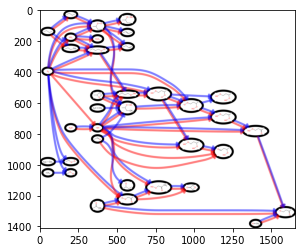

In [26]:
graph.write_dot('mechanism_flux.dot')
graph.write_png('mechanism_flux.png')
img = mpimg.imread('mechanism_flux.png')
imgplot = plt.imshow(img)

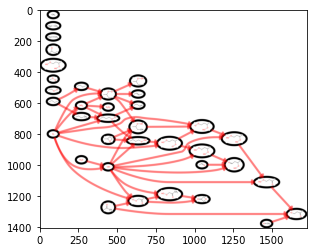

In [27]:
# delete all edges
for nodeA in graph.get_nodes():
    for nodeB in graph.get_nodes():
        graph.del_edge(nodeA, nodeB)
        graph.del_edge(nodeA, nodeB)

# remake plot 1:
for reactant_index, product_index in edges1:
    if reactant_index in nodes and product_index in nodes:
        reactant = species_list1[reactant_index]
        product = species_list1[product_index]
        edge = pydot.Edge(str(reactant), str(product), color='#ff000080')
        edge.set_penwidth(max_edge_pen_width)
        graph.add_edge(edge)
        
        
graph.write_dot('mechanism_flux1.dot')
graph.write_png('mechanism_flux1.png')
img = mpimg.imread('mechanism_flux1.png')
imgplot = plt.imshow(img)

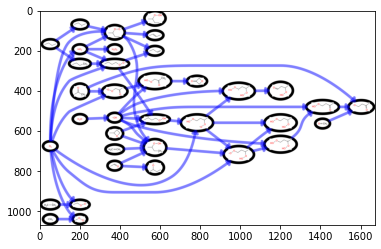

In [28]:
# delete all edges
for nodeA in graph.get_nodes():
    for nodeB in graph.get_nodes():
        graph.del_edge(nodeA, nodeB)
        graph.del_edge(nodeA, nodeB)
        
# remake plot 2:
for reactant_index, product_index in edges2:
    if reactant_index in nodes and product_index in nodes:
        reactant = species_list2[reactant_index]
        product = species_list2[product_index]
        edge = pydot.Edge(str(reactant), str(product), color='#0000ff80')
        edge.set_penwidth(max_edge_pen_width)
        graph.add_edge(edge)
        
graph.write_dot('mechanism_flux2.dot')
graph.write_png('mechanism_flux2.png')
img = mpimg.imread('mechanism_flux2.png')
imgplot = plt.imshow(img)

In [ ]:
dir(graph)

In [ ]:
nodes